> by Cengizhan Aydin (cay7466) and Viktoriia Simakova (vsi3776)

# Computer Vision Features Notebook

This notebook contains exercises for the computer vision features material.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
!python -m wget https://github.com/shegenbart/Jupyter-Exercises/raw/main/data/lemur_img.png -o lemur_img.png


Saved under lemur_img.png


### Exercise 1 - Derive the min-max normalization.

Derive the min-max normalization from the following constraints:

i.) $f(x) := kx + d$

ii.) $f(max) = 1$

iii.) $f(min) = 0$


*Notice:* Put your derivation in the next cell (you can either use latex notation inside markdown or a foto).

$f(max) := k * max + d = 1$

$f(min) := k * min + d = 0$

---

$f(min) := k * min + d = 0$

$k * min = -d$

$-(k * min) = d$

---

$f(max) := k * max + d = 1$

$k * max - k * min = 1$

$k * (max - min) = 1$

$\frac{1}{max - min} = k$

---

$f(x) = k * x + d$

$f(x) = \frac{1}{max - min} * x - \frac{1}{max - min} * min$

$f(x) = \frac{x}{max - min} - \frac{min}{max - min}$

$f(x) = \frac{x - min}{max - min}$

### Exercise 2 - Implement the min-max normalization.

Use the formula you derived in the previous exercise and implement the min-max normalization for a given numpy array.  

In [3]:
def normalize(img):

    img_height, img_width, img_channels = img.shape

    min = np.min(img);
    max = np.max(img);

    norm_img = (img - min) / (max - min)

    return norm_img

img = cv2.imread('lemur_img.png')
norm_img = normalize(img)

print(np.min(img), np.max(img))
print(np.min(norm_img), np.max(norm_img))

0 255
0.0 1.0


### Exercise 3 - Histograms:

Implement a function to compute a histogram (using a user supplied number of bins) for a given image. Notice that histograms are usually computed for each color channel separately.

* Make sure your implementation can deal with normalized data (i.e. in a range of 0 and 1).
* Plot your histograms of each color channel using matplotlibs ```bar()``` function.


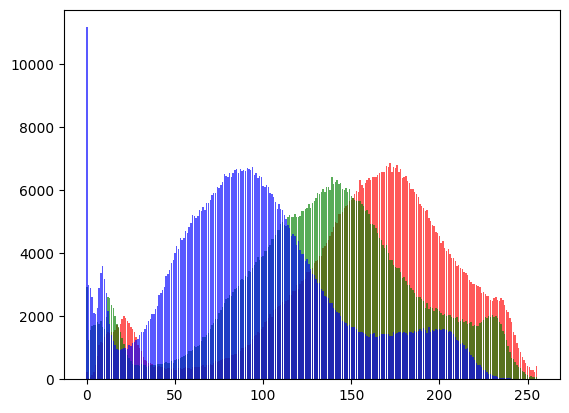

In [4]:
img = cv2.imread('lemur_img.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def hist(img):


    for channel in range(img.shape[2]):
        values, counts = np.unique(img[:,:,channel], return_counts=True)

        if channel == 0:
            color = 'red'
        elif channel == 1:
            color = 'green'
        else:
            color = 'blue'

        plt.bar(values, counts, color=color, alpha=0.65)

    pass

hist(img)

### Exercise 4 - Scale Invariant Feature Transform:

* Compute the SIFT descriptors for the provided images (sift1_img.png and sift2_img.png). See https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html for a tutorial how to use openCV to compute SIFT descriptors.

* Use an openCV feature matcher (https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html) to match your descriptors and visualize the matches as shown in the slides.




In [10]:
!python -m wget https://github.com/shegenbart/Jupyter-Exercises/raw/main/data/sift1_img.png -o sift1_img.png
!python -m wget https://github.com/shegenbart/Jupyter-Exercises/raw/main/data/sift2_img.png -o sift2_img.png


Saved under sift1_img.png

Saved under sift2_img.png


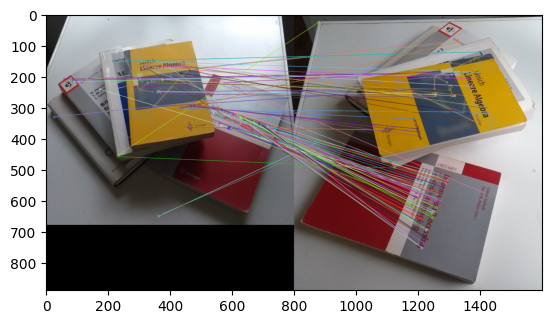

In [5]:
sift1 = cv2.imread('sift1_img.png')
sift2 = cv2.imread('sift2_img.png')

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(sift1, None)
kp2, des2 = sift.detectAndCompute(sift2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good = []

for m,n in matches:
  if m.distance < 0.75 * n.distance:
    good.append([m])

img3 = cv2.drawMatchesKnn(sift1, kp1, sift2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

plt.imshow(img3)
plt.show()

### Exercise 5 -  Local Binary Patterns:

It is now time to develop the full computer vision pipeline to classify some images.

1. Implement Local Binary Patterns (to do so use a simple 8-neighborhood).
2. Write a method to compute grayscale histograms (not lbp-histograms) for all image data (X_train and X_test). Re-use your implementation from before.
3. Write a method to compute lbp histograms for all image data (X_train and X_test).
4. Train two separate Neural Networks and classify the data using:
    * The grayscale histograms as features
    * The lbp-histograms as features
    
Notice: You will need to one-hot-encode the labels of the dataset to train a neural network (why?). Use the ```tf.keras.utils.to_categorical(Y)``` method to encode your labels accordingly.

Compare and interpret your results, what would you expect? Can you explain the results?



    





In [4]:
!python -m wget https://github.com/shegenbart/Jupyter-Exercises/raw/main/data/kth_tips.pbz2 -o kth_tips.pbz2


Saved under kth_tips.pbz2


In [2]:
import pickle, bz2
from sklearn.model_selection import train_test_split
import tensorflow as tf

with bz2.BZ2File('./kth_tips.pbz2', 'rb') as fd:
    kth_dataset = pickle.load(fd)

X_train, X_test, Y_train, Y_test = train_test_split(kth_dataset['X'], kth_dataset['Y'], random_state=12345)


In [4]:
import numpy as np

def local_binary_pattern(matrix):
  result = np.zeros(8)
  position = 0
  for x in range(0,matrix.shape[0]):
    for y in range(0,matrix.shape[1]):
      if x == 1 and y == 1:
        continue
      result[position] = 0 if matrix[1][1] > matrix[x][y] else 1
      position+=1
  dez = 0
  for i in range(len(result)):
    dez += 2**i if result[i] == 1 else 0
  return dez

def binary_pattern_image(img):
  result = []
  for x in range(1,img.shape[0]-1):
    for y in range(1,img.shape[1]-1):
      result.append(local_binary_pattern(img[x-1:x+2,y-1:y+2]))

  counter = np.zeros(256)
  for i in range(len(result)):
    counter[result[i]] += 1;
  return counter

def count_occurences(img):
  counter = np.zeros(256)
  for x in range(200):
    for y in range(200):
      counter[int(img[x][y])] +=1
  return counter


In [5]:
X_train_normalized = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test_normalized = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

In [6]:
X_train_lbp = []
for i in range(X_train_normalized.shape[0]):
    X_train_lbp.append(binary_pattern_image(X_train_normalized[i, :, :]))

X_test_lbp = []
for i in range(X_test_normalized.shape[0]):
    X_test_lbp.append(binary_pattern_image(X_test_normalized[i, :, :]))

X_train_gray = []
for i in range(X_train_normalized.shape[0]):
    X_train_gray.append(np.histogram(X_train_normalized[i, :, :], bins=range(256))[0])

X_test_gray = []
for i in range(X_test_normalized.shape[0]):
    X_test_gray.append(np.histogram(X_test_normalized[i, :, :], bins=range(256))[0])

In [7]:
Y_train_encoded = tf.keras.utils.to_categorical(Y_train)
Y_test_encoded = tf.keras.utils.to_categorical(Y_test)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model = Sequential()
model.add(Input(shape=(256,)))
model.add(Dense(50, use_bias=True, activation="relu"))
model.add(Dense(50, use_bias=True, activation="relu"))
model.add(Dense(50, use_bias=True, activation="relu"))
model.add(Dense(50, use_bias=True, activation="relu"))
model.add(Dense(50, use_bias=True, activation="relu"))
model.add(Dense(50, use_bias=True, activation="relu"))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer=Adam(),  # Optimizer
    # Loss function to minimize
    loss=CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=["accuracy"],
)

epochs = 200

history = model.fit(
    np.array(X_train_lbp),
    Y_train_encoded,
    batch_size=32,
    epochs=epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(np.array(X_test_lbp), Y_test_encoded),
)

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1420 - loss: 40.6277 - val_accuracy: 0.3892 - val_loss: 5.8068
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3620 - loss: 4.6642 - val_accuracy: 0.4236 - val_loss: 3.0678
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5332 - loss: 2.1036 - val_accuracy: 0.5025 - val_loss: 2.1230
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6123 - loss: 1.4582 - val_accuracy: 0.5862 - val_loss: 1.5251
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6729 - loss: 1.2265 - val_accuracy: 0.6453 - val_loss: 1.5163
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7385 - loss: 0.8959 - val_accuracy: 0.6995 - val_loss: 1.2342
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7653 - loss: 0.6607 - val_accuracy: 0.6847 - val_loss: 1.1021
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7749 - loss: 0.7204 - val_accuracy: 0.7241 - 

In [18]:
_, acc = model.evaluate(np.array(X_test_lbp), Y_test_encoded, verbose=0)
print(f"Accuracy: {acc*100:.2f}%")

Accuracy: 92.61%


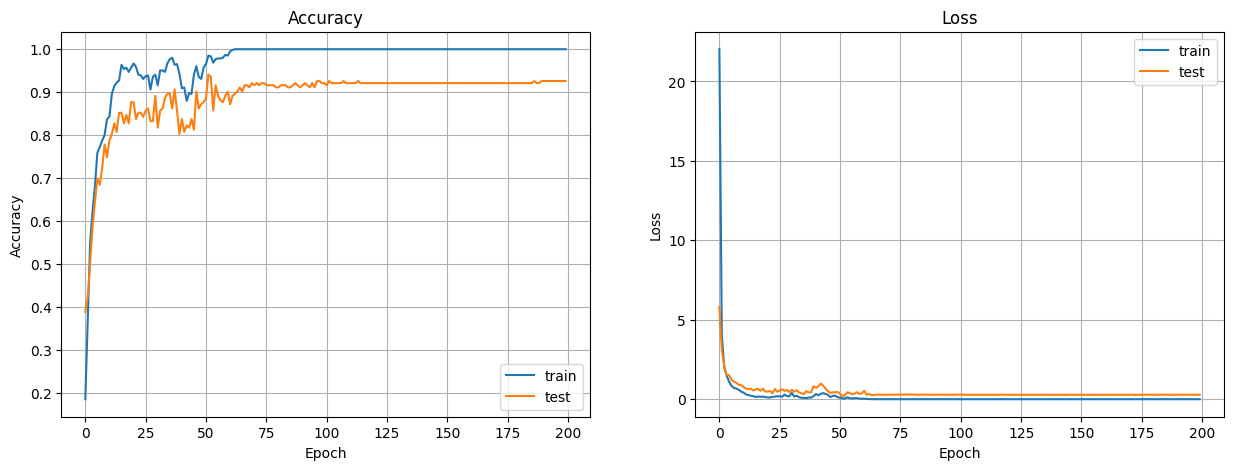

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(history.history["accuracy"], label="train")
axs[0].plot(history.history["val_accuracy"], label="test")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].legend()
axs[0].set_title("Accuracy")
axs[0].grid()

axs[1].plot(history.history["loss"], label="train")
axs[1].plot(history.history["val_loss"], label="test")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].legend()
axs[1].set_title("Loss")
axs[1].grid()


<img src="https://i.redd.it/w546ujwux4m01.png" width=400 />